# Determining a good quantizer

## Imports

In [2]:
import os
from os.path import isfile
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pprint
import skimage.metrics
import matplotlib.pyplot as plt

## Parameters

In [23]:
param = {
    "path_base": "/tmp/",
    "folders": ["din", "dout"],    
    "url_video": "https://media.xiph.org/video/derf/y4m/galleon_422_qcif.y4m",
    "name_video": "galleon_422_qcif.y4m",     
    "limite": 5, 
    "T": 4, 
    "q_inicial": 2, 
    "q_step": 128, 
    "distorsion_metric": "MSE", 
    "predictor": 2,
    "quantizers" : ["midtread", "midrise", "deadzone"]    
}
resultados = {   
    "size_original" : 0,
    "q_step": []
}

## Functions

In [24]:
#Crear carpetas
#---------------------------------------------
def make_directories (di, do, c):
    for i in c:
        !mkdir {di}/{i}
        !mkdir {do}/{i}
        !cp {do}/*.* {do}/{i}/        

#Calcula el tamaño de una carpeta
def get_size(the_path):
    """Get size of a directory tree in bytes."""
    path_size = 0
    for path, dirs, files in os.walk(the_path):
        for fil in files:
            filename = os.path.join(path, fil)
            path_size += os.path.getsize(filename)
    return path_size

#Calcular los valores para q_step
#---------------------------------------------
def set_qstep(i_q_inicial, i_q_step):
    q_step_temp = []    
    i = i_q_inicial
    while i <= i_q_step:
        q_step_temp.append(i); i=i*2
    return q_step_temp

#Cuantificar las imágenes
#---------------------------------------------
def cuantify(q, j, ii):
    !python3 ../tools/quantizeissue1.py -i /tmp/{q}/mcdwt/LH{ii}.png -o /tmp/{q}/{j}/LH{ii}.png -q {q} -c {j} 
    !python3 ../tools/quantizeissue1.py -i /tmp/{q}/mcdwt/HL{ii}.png -o /tmp/{q}/{j}/HL{ii}.png -q {q} -c {j} 
    !python3 ../tools/quantizeissue1.py -i /tmp/{q}/mcdwt/HH{ii}.png -o /tmp/{q}/{j}/HH{ii}.png -q {q} -c {j} 
    !python3 ../tools/quantizeissue1.py -i /tmp/{q}/mcdwt/LL{ii}.png -o /tmp/{q}/{j}/LL{ii}.png -q {q} -c {j} 
#Obtener las inversas
#---------------------------------------------
def get_inverse(q, j):
    !python3 -O MCDWT.py -P {param["predictor"]} -p /tmp/{q}/{j}/inversas/ -b  
    !cd /home/ubuntu/MCDWT/src/
    !python3 -O MDWT.py -p /tmp/{q}/{j}/inversas/ -b       
        
#Obtener MSE entre dos carpetas
#---------------------------------------------
def MSE(original, inversa):
    mse_temp = 0
    i = 0
    for a in os.listdir(original):
        if isfile(original + a):
            mse_temp += get_MSE(original + a, inversa + a)
            i += 1
    return(mse_temp / i)

#Obtener los pesos de las carpetas q y cuantificador
#---------------------------------------------
def get_pesos(cuantificador, q):
        path = "/tmp/"+str(q)+"/"+str(cuantificador) + "/"
        total = 0.0
        for i in range(5):
            path_archivo_reducido = os.path.join(path,"LL{:03d}".format(i)+".png")
            total += os.stat(path_archivo_reducido).st_size
            path_archivo_reducido = os.path.join(path,"LH{:03d}".format(i)+".png")
            total += os.stat(path_archivo_reducido).st_size
            path_archivo_reducido = os.path.join(path,"HL{:03d}".format(i)+".png")
            total += os.stat(path_archivo_reducido).st_size
            path_archivo_reducido = os.path.join(path,"HH{:03d}".format(i)+".png")
            total += os.stat(path_archivo_reducido).st_size
        return total

#Obtener MSE entre dos archivos
#---------------------------------------------
def get_MSE(cuantificador,original,q):
        cuantizada = "/tmp/"+str(q)+"/"+cuantificador+"/inversas/"+"{:03d}".format(original)+".png"
        original = "/tmp/din/original/"+"{:03d}".format(original)+".png"
        x = cv2.imread(original, -1)
        y = cv2.imread(cuantizada, -1)
        MSE = skimage.metrics.mean_squared_error(x, y)
        return MSE

## Step 1a: Copy stockolm image & makes directories

In [26]:
!mkdir /tmp/din
!mkdir /tmp/din/original
!mkdir /tmp/din/mcdwt
resultados["size_original"] = get_size(param["path_base"] + param["folders"][0] + "/")
resultados["q_step"] = set_qstep(param["q_inicial"], param["q_step"])
!cp /home/ubuntu/MCDWT/sequences/stockholm/* /tmp/din/original/

!cp /tmp/din/original/* /tmp/din/mcdwt/
!sh issue0-iteration_mcdwt.sh din/mcdwt 5

for q in resultados["q_step"]:    
    !mkdir /tmp/{q}
    !mkdir /tmp/{q}/mcdwt
    !cp /tmp/din/mcdwt/* /tmp/{q}/mcdwt/  
    for j in param["quantizers"]: 
        !mkdir /tmp/{q}/{j}
        !mkdir /tmp/{q}/{j}/inversas

## Step 1b: Download, extract images & makes directories

In [6]:
!mkdir /tmp/din
!mkdir /tmp/din/original
!mkdir /tmp/din/mcdwt
resultados["size_original"] = get_size(param["path_base"] + param["folders"][0] + "/")
resultados["q_step"] = set_qstep(param["q_inicial"], param["q_step"])

!wget {param.get("url_video")}
lim = param.get("limite")
name_video = param.get("name_video")
!ffmpeg -i {name_video} -vframes {lim} /tmp/din/original/%03d.png
!sh issue0-corregir_png.sh din/original
!cp /tmp/din/original/* /tmp/din/mcdwt/
!sh issue0-iteration_mcdwt.sh din/mcdwt 5

for q in resultados["q_step"]:    
    !mkdir /tmp/{q}
    !mkdir /tmp/{q}/mcdwt
    !cp /tmp/din/mcdwt/* /tmp/{q}/mcdwt/  
    for j in param["quantizers"]: 
        !mkdir /tmp/{q}/{j}
        !mkdir /tmp/{q}/{j}/inversas

--2020-02-10 23:25:31--  https://media.xiph.org/video/derf/y4m/galleon_422_qcif.y4m
Resolving media.xiph.org (media.xiph.org)... 54.39.18.101, 2607:5300:203:2965::
Connecting to media.xiph.org (media.xiph.org)|54.39.18.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18249883 (17M)
Saving to: ‘galleon_422_qcif.y4m.19’

galleon_422_qcif.y4 100%[===================>]  17.40M  1.21MB/s    in 15s     

2020-02-10 23:25:47 (1.16 MB/s) - ‘galleon_422_qcif.y4m.19’ saved [18249883/18249883]

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enab

## Step 2: Quantizers

In [7]:
for q in resultados["q_step"]:    
    for j in param["quantizers"]: 
        for imagen in range(0,5):
            ii ="{:03d}".format(imagen)
            cuantify(q, j, ii) #cuantificar    

Quantizing with step 2
Max value at output: 152
Min value at output: -146
Quantizing with step 2
Max value at output: 82
Min value at output: -100
Quantizing with step 2
Max value at output: 24
Min value at output: -24
Quantizing with step 2
Max value at output: 776
Min value at output: -136
Quantizing with step 2
Max value at output: 96
Min value at output: -90
Quantizing with step 2
Max value at output: 60
Min value at output: -64
Quantizing with step 2
Max value at output: 18
Min value at output: -18
Quantizing with step 2
Max value at output: 782
Min value at output: -128
Quantizing with step 2
Max value at output: 88
Min value at output: -76
Quantizing with step 2
Max value at output: 80
Min value at output: -76
Quantizing with step 2
Max value at output: 18
Min value at output: -24
Quantizing with step 2
Max value at output: 732
Min value at output: -124
Quantizing with step 2
Max value at output: 84
Min value at output: -64
Quantizing with step 2
Max value at output: 72
Min valu

Quantizing with step 4
Max value at output: 728
Min value at output: -124
Quantizing with step 4
Max value at output: 84
Min value at output: -64
Quantizing with step 4
Max value at output: 68
Min value at output: -64
Quantizing with step 4
Max value at output: 20
Min value at output: -20
Quantizing with step 4
Max value at output: 744
Min value at output: -140
Quantizing with step 4
Max value at output: 132
Min value at output: -144
Quantizing with step 4
Max value at output: 96
Min value at output: -80
Quantizing with step 4
Max value at output: 24
Min value at output: -28
Quantizing with step 4
Max value at output: 748
Min value at output: -148
Quantizing with step 8
Max value at output: 152
Min value at output: -144
Quantizing with step 8
Max value at output: 80
Min value at output: -96
Quantizing with step 8
Max value at output: 24
Min value at output: -24
Quantizing with step 8
Max value at output: 776
Min value at output: -136
Quantizing with step 8
Max value at output: 96
Min v

Quantizing with step 16
Max value at output: 80
Min value at output: -96
Quantizing with step 16
Max value at output: 16
Min value at output: -16
Quantizing with step 16
Max value at output: 768
Min value at output: -128
Quantizing with step 16
Max value at output: 80
Min value at output: -80
Quantizing with step 16
Max value at output: 48
Min value at output: -64
Quantizing with step 16
Max value at output: 16
Min value at output: -16
Quantizing with step 16
Max value at output: 768
Min value at output: -112
Quantizing with step 16
Max value at output: 80
Min value at output: -64
Quantizing with step 16
Max value at output: 80
Min value at output: -64
Quantizing with step 16
Max value at output: 16
Min value at output: -16
Quantizing with step 16
Max value at output: 720
Min value at output: -112
Quantizing with step 16
Max value at output: 80
Min value at output: -64
Quantizing with step 16
Max value at output: 64
Min value at output: -64
Quantizing with step 16
Max value at output: 

Quantizing with step 64
Max value at output: 736.0
Min value at output: -96.0
Quantizing with step 64
Max value at output: 96.0
Min value at output: -96.0
Quantizing with step 64
Max value at output: 96.0
Min value at output: -96.0
Quantizing with step 64
Max value at output: 32.0
Min value at output: -32.0
Quantizing with step 64
Max value at output: 736.0
Min value at output: -160.0
Quantizing with step 64
Max value at output: 160.0
Min value at output: -160.0
Quantizing with step 64
Max value at output: 96.0
Min value at output: -96.0
Quantizing with step 64
Max value at output: 32.0
Min value at output: -32.0
Quantizing with step 64
Max value at output: 736.0
Min value at output: -160.0
Quantizing with step 64
Max value at output: 128
Min value at output: -128
Quantizing with step 64
Max value at output: 64
Min value at output: -64
Quantizing with step 64
Max value at output: 0
Min value at output: 0
Quantizing with step 64
Max value at output: 768
Min value at output: -128
Quantiz

## Step 3: Get inverse

In [8]:
for q in resultados["q_step"]:    
    for j in param["quantizers"]:        
        !cp /tmp/{q}/{j}/* /tmp/{q}/{j}/inversas
        !cd /home/ubuntu/MCDWT/src/
        get_inverse(q,j)       

cp: -r not specified; omitting directory '/tmp/2/midtread/inversas'
cp: -r not specified; omitting directory '/tmp/2/midrise/inversas'
cp: -r not specified; omitting directory '/tmp/2/deadzone/inversas'
cp: -r not specified; omitting directory '/tmp/4/midtread/inversas'
cp: -r not specified; omitting directory '/tmp/4/midrise/inversas'
cp: -r not specified; omitting directory '/tmp/4/deadzone/inversas'
cp: -r not specified; omitting directory '/tmp/8/midtread/inversas'
cp: -r not specified; omitting directory '/tmp/8/midrise/inversas'
cp: -r not specified; omitting directory '/tmp/8/deadzone/inversas'
cp: -r not specified; omitting directory '/tmp/16/midtread/inversas'
cp: -r not specified; omitting directory '/tmp/16/midrise/inversas'
cp: -r not specified; omitting directory '/tmp/16/deadzone/inversas'
cp: -r not specified; omitting directory '/tmp/32/midtread/inversas'
cp: -r not specified; omitting directory '/tmp/32/midrise/inversas'
cp: -r not specified; omitting directory '/tmp/3

## Step 4: Group result and evaluate

In [9]:
totales = {"deadzone" : [],"midtread" : [],"midrise" : []}
for q in resultados["q_step"]:    
    for j in param["quantizers"]:
        MSE_suma = 0.0
        pesos = get_pesos(str(j),q)
        for i in range(param["limite"]):
            MSE_suma+= get_MSE(j,i,q)
        totales[j].append([pesos,MSE_suma/param["limite"]]) 
print(totales)

{'deadzone': [[11986975.0, 3.4866901312934027], [8217073.0, 7.631136271158854], [4565118.0, 18.17201633029514], [2440047.0, 42.70552585177951], [1638308.0, 103.2231748453776], [1127947.0, 304.39951768663195], [641711.0, 1154.396639404297]], 'midtread': [[12149386.0, 3.4819852701822915], [9548160.0, 5.088123847113716], [6436365.0, 9.36474833170573], [3591537.0, 17.915440402560765], [1900898.0, 32.48057244194879], [1202878.0, 70.43649013943141], [791041.0, 225.629705335829]], 'midrise': [[12567064.0, 1.9656651475694447], [10509253.0, 4.441024644639757], [8736891.0, 16.51632331000434], [7557734.0, 76.67837673611112], [6896268.0, 365.4428603108724], [6415217.0, 1660.467719455295], [5173187.0, 7310.202056274415]]}


## Step 5: Graphics

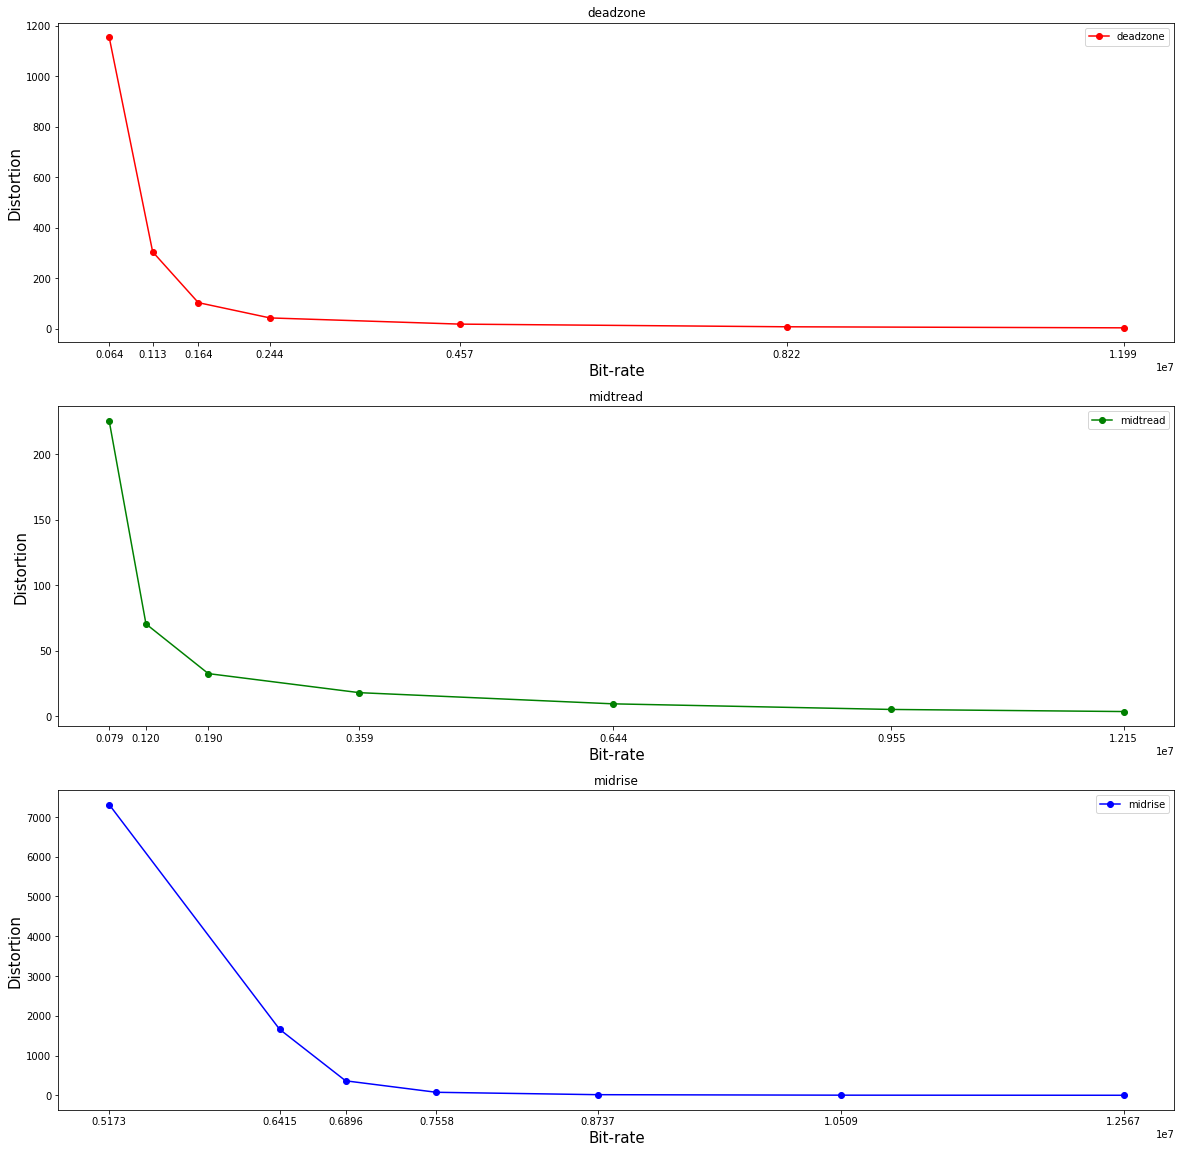

In [21]:
colores={'midrise':"b", "midtread":"g", "deadzone":"r"}
fig=plt.figure(figsize=(20,20))
spec = fig.add_gridspec(ncols=1, nrows=3)
n = 311
for tipo in totales:
    plt.subplot(n)
    plot = plt.plot([i[0] for i in totales[tipo]],[i[1] for i in totales[tipo]],'-bo', color=colores[tipo],label =tipo, linestyle='-')
    plt.xticks([i[0] for i in totales[tipo]])
    plt.ylabel("Distortion", fontsize = 15, color = 'black')
    plt.xlabel("Bit-rate", fontsize = 15, color = 'black')
    plt.title(tipo)
    plt.legend(loc="upper right")
    n+=1

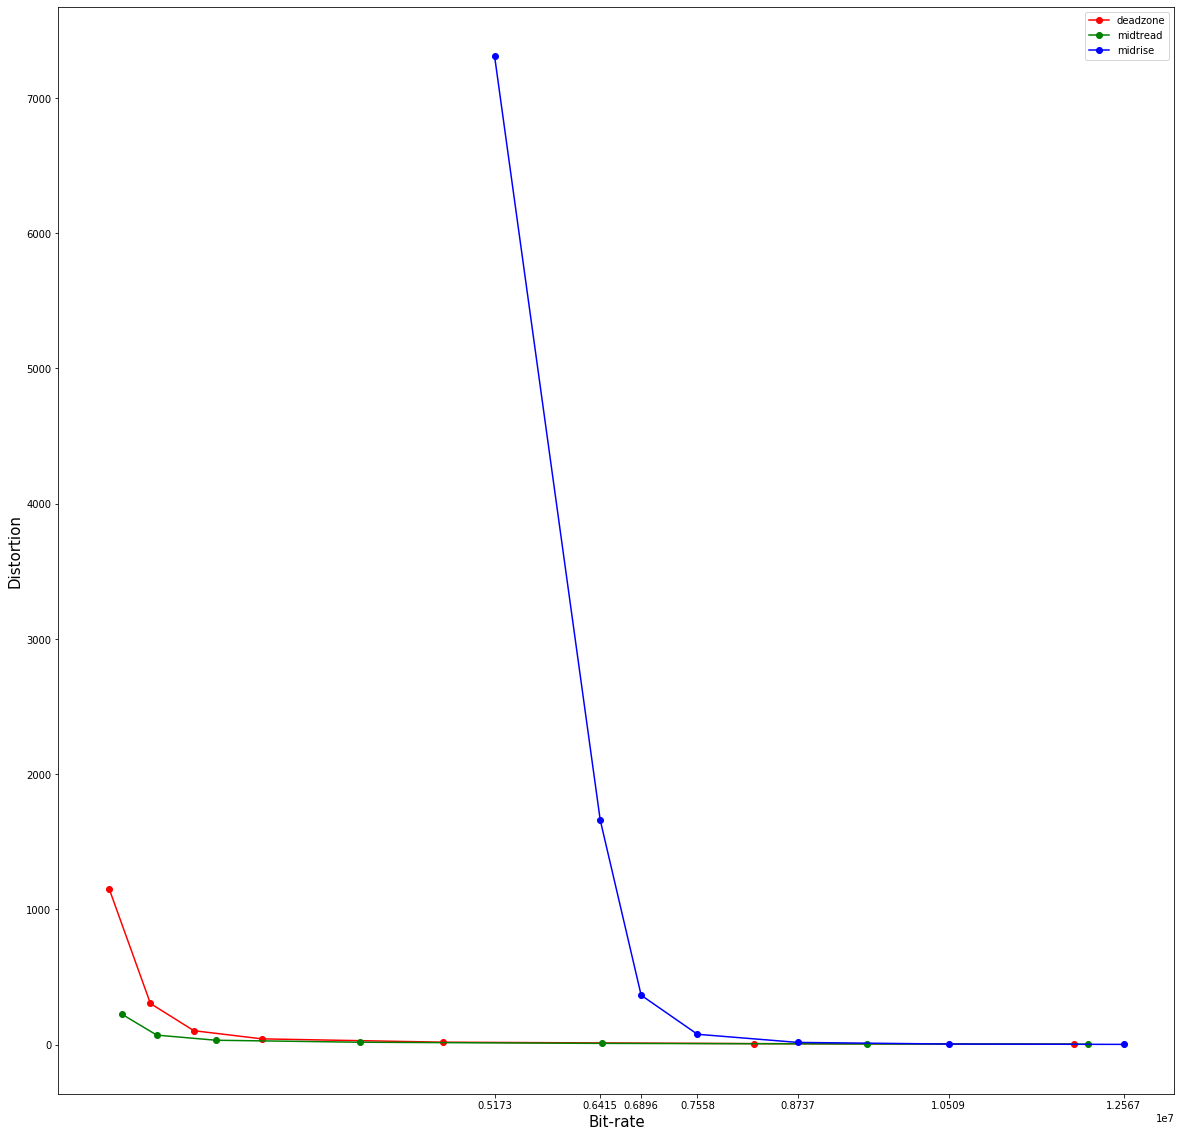

In [19]:
colores={'midrise':"b", "midtread":"g", "deadzone":"r"}
fig=plt.figure(figsize=(20,20))
spec = fig.add_gridspec(ncols=1, nrows=3)
for tipo in totales:
    plot = plt.plot([i[0] for i in totales[tipo]],[i[1] for i in totales[tipo]],'-bo', color=colores[tipo],label=str(tipo), linestyle='-')
    plt.xticks([i[0] for i in totales[tipo]])
plt.ylabel("Distortion", fontsize = 15, color = 'black')
plt.xlabel("Bit-rate", fontsize = 15, color = 'black')
plt.legend(loc="upper right")
plt.show()